# Installation

With conda, you can install the required dependencies with:

```bash
conda install beautifulsoup4 requests
```


# Basic usage of BeautifulSoup

First, we import the `BeatifulSoup` class:

In [1]:
from bs4 import BeautifulSoup

We load the html source file from disk and pass the source the the BeautifulSoup constructor.

In [11]:
with open("list.html") as f:
    document = BeautifulSoup(f, "html.parser")
print(document)

<!DOCTYPE html>

<html>
<body>
<h2>An Unordered HTML List</h2>
<ul id="unordered_list" style="color:#069">
<li>
      Coffee
  </li>
<li>
      Tea
  </li>
<li>
      Milk
  </li>
</ul>
<h2>An Ordered HTML List</h2>
<ol id="ordered_list" style="color:#069">
<li>Coffee</li>
<li>Tea</li>
<li>Milk</li>
</ol>
</body>
</html>



### Finding tags by name

The document now contains the full html document. We can find the first occuring tag with a specific name with the `find` function. Let's find the first un-ordered list tag:

In [12]:
ulist = document.find("ul")

The result contains all tags contained in the matched tag:

In [13]:
ulist

<ul id="unordered_list" style="color:#069">
<li>
      Coffee
  </li>
<li>
      Tea
  </li>
<li>
      Milk
  </li>
</ul>

The `find_all` function returns **all** tags that match the given tag name. We can use it to get a list of all list items:

In [14]:
items = ulist.find_all("li")
items

[<li>
       Coffee
   </li>,
 <li>
       Tea
   </li>,
 <li>
       Milk
   </li>]

Finally, we can loop over all items and extract their contant with the `get_text` function:

In [15]:
for item in items:
    print(repr(item.get_text()))

'\n      Coffee\n  '
'\n      Tea\n  '
'\n      Milk\n  '


Because whitespace is not meaningful in HTML,
it is often useful to strip it when you are getting the content of a tag.
You can do this with `strip=True`

In [16]:
for item in items:
    print(repr(item.get_text(strip=True)))

'Coffee'
'Tea'
'Milk'


Note that `find_all` is **recursive** by default. This means that we could call it the on the full `document` to get the items
of both the ordered and un-ordered lists:

In [17]:
document.find_all("li", recursive=False)

[]

A recursive search finds all `li` tags anywhere.

In [18]:
document.find_all("li")

[<li>
       Coffee
   </li>,
 <li>
       Tea
   </li>,
 <li>
       Milk
   </li>,
 <li>Coffee</li>,
 <li>Tea</li>,
 <li>Milk</li>]

### Finding tags by attributes

Sometimes the easiest way to find a tag is by its attribute name. In our examples, both lists have an `id` attribute that uniquely identifies the tables. We can also use the `find*` methods to search for attributes:


In [19]:
document.find(attrs={"id": "unordered_list"})

<ul id="unordered_list" style="color:#069">
<li>
      Coffee
  </li>
<li>
      Tea
  </li>
<li>
      Milk
  </li>
</ul>

### Accessing attributes

The `ul` tag also contains a `style` attribute. Any bs4 tag behaves like a dictionary with attribute names as keys and attribute values as values:

In [20]:
ulist.attrs

{'id': 'unordered_list', 'style': 'color:#069'}

In [21]:
ulist["style"]

'color:#069'

# Downloading a table from Wikipedia

We aim to get a list of countries sorted by their population size:
https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population

First, let's import the required modules:

In [22]:
import requests
from bs4 import BeautifulSoup
import re
import dateutil

This time, we load the html source directly from a website using the requests module:

In [26]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population")

The web server returns a status code to indicate if the request was (un-)succesfully.
We use that status-code to check if the page was succesfully loaded:

In [27]:
assert r.status_code == 200

Next, we extract the html source and initiated BeautifulSoup:

In [29]:
html = result.text
document = BeautifulSoup(html, "html.parser")

by looking at the document, we can see that we are interested in first table. So we use `find`:

In [30]:
table = document.find("table")

If you are not familiar with html table, read this example first: https://www.w3schools.com/html/tryit.asp?filename=tryhtml_table_intro

In [32]:
print(str(table)[:1024])

<table class="wikitable sortable">
<tbody><tr>
<th>Rank</th>
<th><a href="/wiki/List_of_sovereign_states" title="List of sovereign states">Country</a> / <a href="/wiki/Dependent_territory" title="Dependent territory">Dependency</a></th>
<th>Population</th>
<th>Percentage of the world</th>
<th>Date</th>
<th><span class="nowrap">Source (official or from</span> the <a href="/wiki/United_Nations" title="United Nations">United Nations</a>)</th>
<th>Notes
</th></tr>
<tr>
<td style="text-align:center"><b>–</b>
</td>
<td><b>World</b>
</td>
<td style="text-align:center"><b> 7,984,158,000</b></td>
<td style="text-align:right"><b>100%</b></td>
<td><b><span data-sort-value="000000002022-10-12-0000" style="white-space:nowrap">12 Oct 2022</span></b></td>
<td style="text-align:left"><b>UN projection<sup class="reference" id="cite_ref-unpop_4-0"><a href="#cite_note-unpop-4">[3]</a></sup></b></td>
<td>
</td></tr>
<tr>
<th>1
</th>
<td scope="row" style="text-align:left"><span class="flagicon"><img alt="

At this point, it is a good idea to programatically check that the table contains the correct header:

In [33]:
assert table.find("th").get_text() == "Rank"

In [34]:
rows = table.find_all("tr")  # Note: this works because find_all is resursive by default

In [45]:
for row in rows[2:-1]:
    cells = row.find_all(["td", "th"])

    cells_text = [cell.get_text(strip=True) for cell in cells]
    (rank, country, population, percentage, updated_at, source, comment) = cells_text

    # Clean population string str("1,404,890,600") -> int(1404890600)
    population = int(population.replace(",", ""))

    # Clean country name
    country = re.findall(r"[\w\s()\.]+", country)[0]

    # Convert percentage to floats
    percentage = float(re.findall(r"[\d\.]+", percentage)[0])

    # Convert updated_at to date object
    updated_at = dateutil.parser.parse(updated_at).date()

    print(f"{rank}, {country}, {population:.2e}, {percentage}%, {updated_at}, {source}")

1, China, 1.41e+09, 17.7%, 2021-12-31, Official estimate[4]
2, India, 1.38e+09, 17.2%, 2022-03-01, Official projection[5]
3, United States, 3.32e+08, 4.16%, 2021-07-01, Official estimate[6]
4, Indonesia, 2.76e+08, 3.45%, 2022-07-01, Official estimate[7]
5, Pakistan, 2.29e+08, 2.87%, 2022-07-01, UN projection[3]
6, Nigeria, 2.17e+08, 2.71%, 2022-07-01, UN projection[3]
7, Brazil, 2.15e+08, 2.7%, 2022-10-12, National population clock[8]
8, Bangladesh, 1.65e+08, 2.07%, 2022-06-15, 2022 preliminary census result[9]
9, Russia, 1.45e+08, 1.82%, 2022-06-01, Official estimate[10]
10, Mexico, 1.29e+08, 1.61%, 2022-06-30, National quarterly estimate[11]
11, Japan, 1.26e+08, 1.58%, 2022-01-01, Official estimate[12]
12, Philippines, 1.13e+08, 1.41%, 2022-10-12, National population clock[13]
13, Ethiopia, 1.05e+08, 1.32%, 2022-07-01, National annual projection[14]
14, Egypt, 1.04e+08, 1.3%, 2022-10-12, National population clock[15]
15, Vietnam, 9.85e+07, 1.23%, 2021-07-01, Official estimate[16]
16,

**Attention**: Beautiful Soup does not execute Javascript. This means that you the code in your browser inspector might look a bit different from the original HTML source code. 

# Another example of downloading a Wikipedia table 

Let's consider another table in a Wikipedia page. This page has a lot more tables, so one challenge will be to pick the right table

https://en.wikipedia.org/wiki/Serena_Williams


We are interested in extracting these two tables:

![Target Wikipedia tables](pictures/wiki_tables.png)

**Exercise**: 

1) Identify the id="The_Players_Championship", by using title = document.find(id="The_Players_Championship")

2) First find all tables below the id in 1) by title.find_all_next('table').

3) Search for headers (th) by table.find('th') for table in tables to identify the "Tournament" header. Remember to use get_text(strip=True)

4) Save all tables with the header "Tournament" into a list tournament_tables. Check the length of the table and reduce it if it is needed.

5) Bonus: Print out the information in the two tables of interest in the terminal

We begin by downloading the webpage and instatiating the BeautifulSoup object:

In [49]:
r = requests.get("https://en.wikipedia.org/wiki/Serena_Williams")
document = BeautifulSoup(r.text, "html.parser")

This page contains a lot of tables without specific attributes that would make it easy to find our table of interest. Further, the same headings of the tables are used for multiple tables, making it difficult to find a table just by its headings:

In [50]:
len(document.find_all("table"))

76

Therefore, we choose another strategy. First, we extract the tag that defines the header just before our tables of interest. That header tag has a unique identifier attribute `id="The_Players_Championship"`. Then we use the `find_all_next` function in BeautifulSoup to extract all following table tags:

In [61]:
singles = document.find(string=re.compile(r"Singles.*"), class_="mw-headline")
singles

<span class="mw-headline" id="Singles:_33_(23–10)">Singles: 33 (23–10)</span>

Now, our tables of interest are the first two tables with the "Tournament" heading. We write a small helper function (a generator https://wiki.python.org/moin/Generators) that returns a table with a given heading:

In [62]:
def find_table_with_heading(document, heading_pat):
    heading_element = document.find(string=heading_pat, class_="mw-headline")
    table = heading_element.find_next("table")
    return table


In [71]:
singles_table = find_table_with_heading(document, re.compile("^Singles.*"))
[th.get_text(strip=True) for th in singles_table.find_all("th")]

['Result', 'Year', 'Tournament', 'Surface', 'Opponents', 'Score']

Next, we can extract the table rows and columns as usual. We only extract the first two tables, as these are the only ones we were interested in:

In [72]:
doubles_table = find_table_with_heading(document, re.compile("^Women's doubles.*"))
[th.get_text(strip=True) for th in doubles_table.find_all("th")]


['Result', 'Year', 'Tournament', 'Surface', 'Partner', 'Opponents', 'Score']

## Exercise:

Convert singles_table HTML data to pandas DataFrame

doubles_table


In [95]:
data = []
for row in singles_table.find_all("tr"):
    cells = row.find_all("td")
    if not cells:
        # e.g. header row
        continue
    values = [cell.get_text(strip=True) for cell in cells]
    # convert year to int
    values[1] = int(values[1])
    # strip trailing (n) notes from events
    values[2] = re.sub(r"\s*\(\d+\)$", "", values[2])
    data.append(values)
data

[['Win', 1999, 'US Open', 'Hard', 'Martina Hingis', '6–3, 7–6(7–4)'],
 ['Loss', 2001, 'US Open', 'Hard', 'Venus Williams', '2–6, 4–6'],
 ['Win', 2002, 'French Open', 'Clay', 'Venus Williams', '7–5, 6–3'],
 ['Win', 2002, 'Wimbledon', 'Grass', 'Venus Williams', '7–6(7–4), 6–3'],
 ['Win', 2002, 'US Open', 'Hard', 'Venus Williams', '6–4, 6–3'],
 ['Win',
  2003,
  'Australian Open',
  'Hard',
  'Venus Williams',
  '7–6(7–4), 3–6, 6–4'],
 ['Win', 2003, 'Wimbledon', 'Grass', 'Venus Williams', '4–6, 6–4, 6–2'],
 ['Loss', 2004, 'Wimbledon', 'Grass', 'Maria Sharapova', '1–6, 4–6'],
 ['Win',
  2005,
  'Australian Open',
  'Hard',
  'Lindsay Davenport',
  '2–6, 6–3, 6–0'],
 ['Win', 2007, 'Australian Open', 'Hard', 'Maria Sharapova', '6–1, 6–2'],
 ['Loss', 2008, 'Wimbledon', 'Grass', 'Venus Williams', '5–7, 4–6'],
 ['Win', 2008, 'US Open', 'Hard', 'Jelena Janković', '6–4, 7–5'],
 ['Win', 2009, 'Australian Open', 'Hard', 'Dinara Safina', '6–0, 6–3'],
 ['Win', 2009, 'Wimbledon', 'Grass', 'Venus Willi

When data is in this form, we can convert it into a DataFrame with pandas.

You'll learn more about pandas next week.

In [96]:
import pandas as pd

headings = [th.get_text(strip=True) for th in singles_table.find_all("th")]
df = pd.DataFrame(data, columns=headings)
df

,Result,Year,Tournament,Surface,Opponents,Score
0,Win,1999,US Open,Hard,Martina Hingis,"6–3, 7–6(7–4)"
1,Loss,2001,US Open,Hard,Venus Williams,"2–6, 4–6"
2,Win,2002,French Open,Clay,Venus Williams,"7–5, 6–3"
3,Win,2002,Wimbledon,Grass,Venus Williams,"7–6(7–4), 6–3"
4,Win,2002,US Open,Hard,Venus Williams,"6–4, 6–3"
5,Win,2003,Australian Open,Hard,Venus Williams,"7–6(7–4), 3–6, 6–4"
6,Win,2003,Wimbledon,Grass,Venus Williams,"4–6, 6–4, 6–2"
7,Loss,2004,Wimbledon,Grass,Maria Sharapova,"1–6, 4–6"
8,Win,2005,Australian Open,Hard,Lindsay Davenport,"2–6, 6–3, 6–0"
9,Win,2007,Australian Open,Hard,Maria Sharapova,"6–1, 6–2"


With pandas, we can filter this data, group it, and plot interesting relationships

In [90]:
results_by_year = df.groupby(["Year", "Result"]).Tournament.count().unstack()
results_by_year

Result,Loss,Win
Year,,
1999,NaN,1.0
2001,1.0,NaN
2002,NaN,3.0
2003,NaN,2.0
2004,1.0,NaN
2005,NaN,1.0
2007,NaN,1.0
2008,1.0,1.0
2009,NaN,2.0


<AxesSubplot:xlabel='Year'>

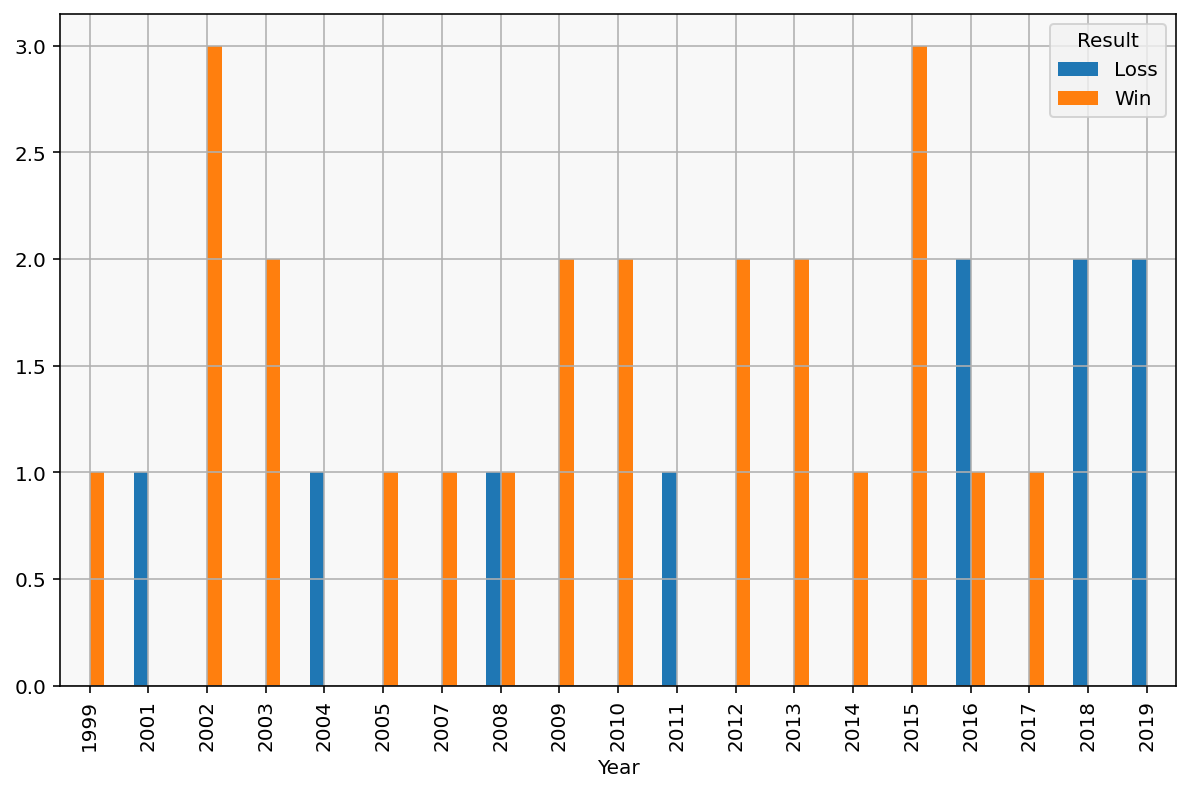

In [91]:
results_by_year.plot(kind="bar")

In [92]:
results_by_surface = df.groupby(["Surface", "Result"]).Tournament.count().unstack()
results_by_surface

Result,Loss,Win
Surface,,
Clay,1,3
Grass,4,7
Hard,5,13


<AxesSubplot:xlabel='Surface'>

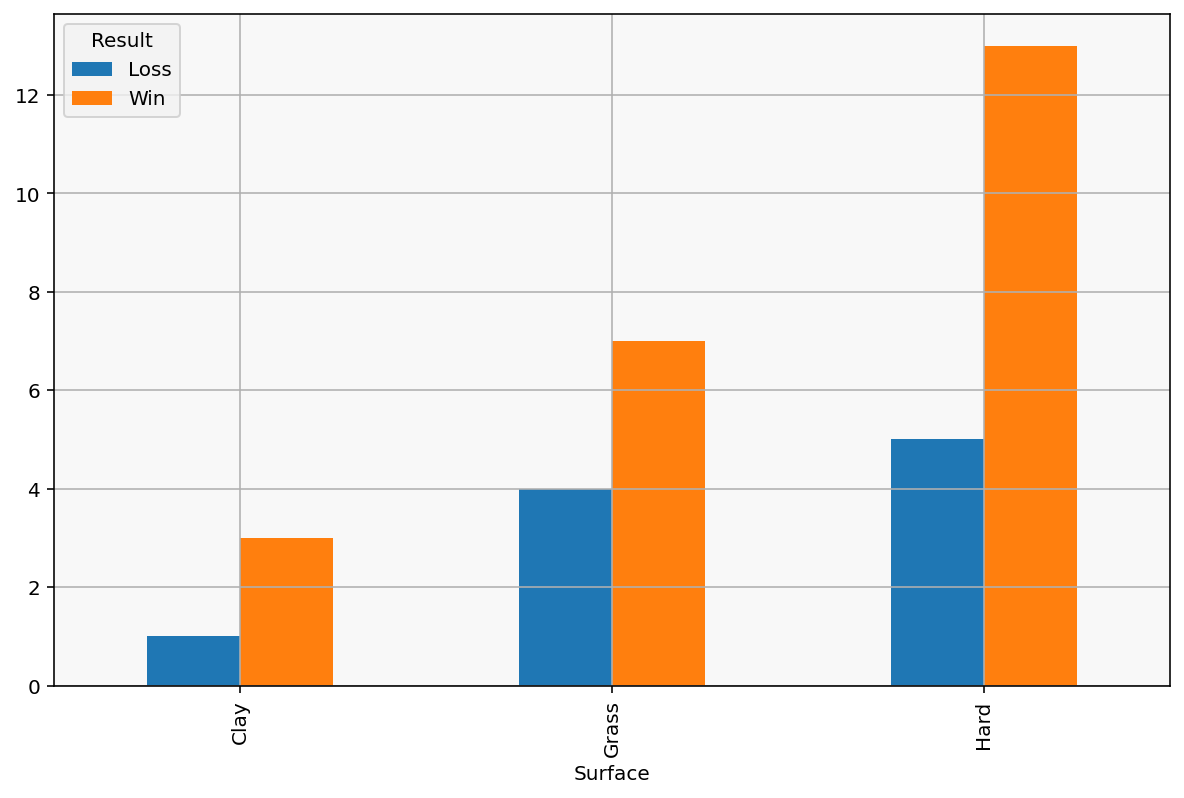

In [94]:
results_by_surface.plot(kind="bar")

<AxesSubplot:xlabel='Opponents'>

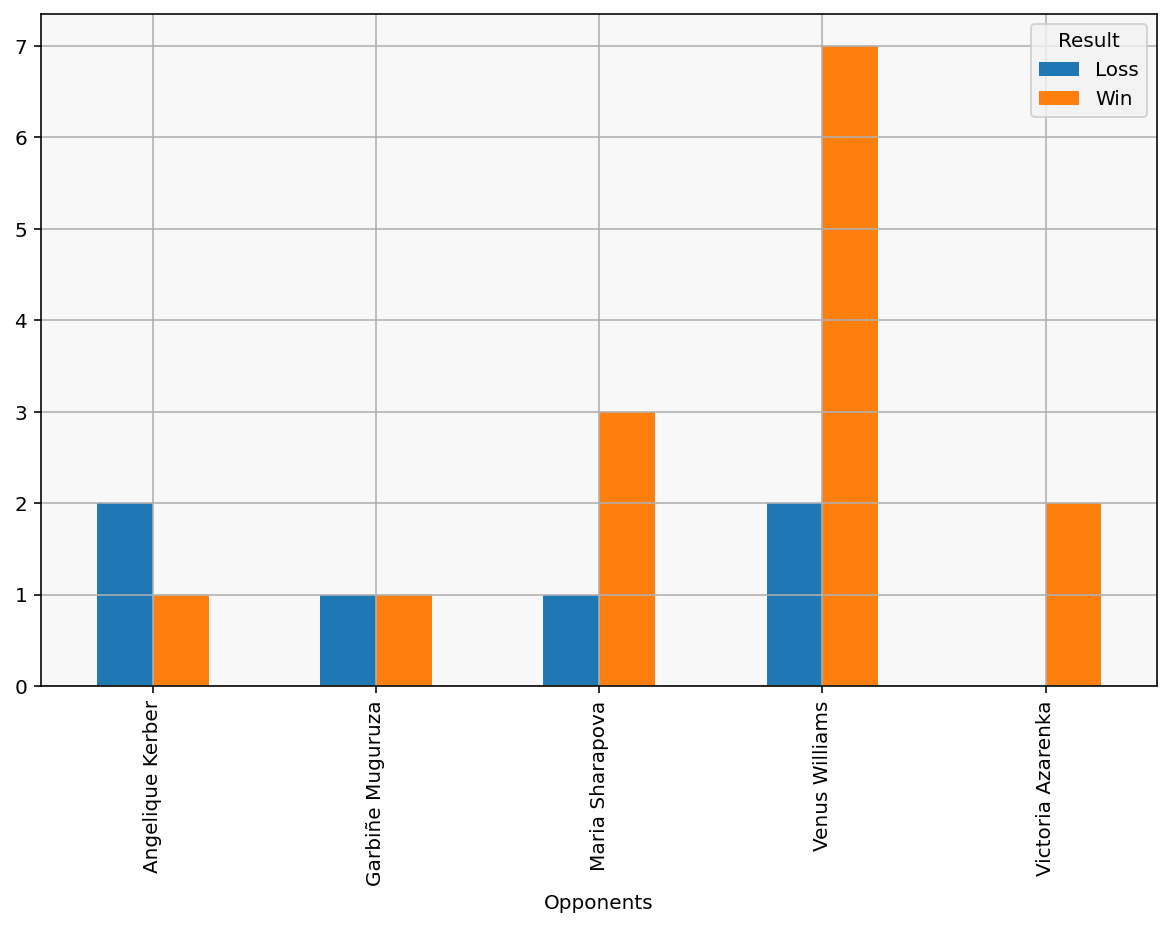

In [107]:
results_by_op = df.groupby(["Opponents", "Result"]).Tournament.count().unstack()

# we can exclude opponents only met once:
results_by_op = results_by_op.fillna(0)
multiple_meetings = results_by_op[(results_by_op.Loss + results_by_op.Win > 1)]
multiple_meetings.plot(kind="bar")


# Exercise:

Find images on the UiO page

1) Go to https://en.wikipedia.org/wiki/University_of_Oslo 
2) Download the content from the site using BeautifulSoup and requests
3) Search for all images (using `images = document.find_all('img')`) and print out the content
4) Include only images with the attribute `class_="thumbimage"` in your list of images. This can be done by inspecting image.attrs. (E.g. `images[0].attrs`)
5) Print out a list of the value of the "src" attribute for the images in 4. 
6) See if you can display an image by pasting a result from 5 into your web-browser. Remember to put https: in front of your string in the web-browser

In [ ]:
r = requests.get...